# Hard Hat Detection Model Training

This notebook demonstrates the training process for a custom YOLO model to detect:
- **Helmet** (class 0)
- **Head** (class 1)  
- **Person** (class 2)

The model is used in the iCAM Factory system for construction site safety monitoring.

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

## Setup

Import required libraries and set up the dataset directory.

In [2]:
DATASET_DIR = "datasets/Hard Hat Workers.v5-raw_headhelmetclasses.yolov11"

# Data Augmentation: Add Person Class

The original dataset only contains helmet and head annotations. We use a pre-trained YOLO11x model to detect and add person bounding boxes to all images. This creates a 3-class dataset: helmet, head, and person.

In [3]:
model = YOLO("pretrained/yolo11x.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

Load a pre-trained YOLO11x model to detect persons (COCO class 0).

In [ ]:
# Add "person" boxes to labels
for folder in ["train", "valid", "test"]:
    for img_file in tqdm(os.listdir(os.path.join(DATASET_DIR, folder, "images"))):
        # Load image
        img_path = os.path.join(DATASET_DIR, folder, "images", img_file)
        img = cv2.imread(img_path)
        
        # Perform inference
        results = model.predict(source=img, conf=0.5, save=False, classes=[0])
        
        # Process results
        label_path = os.path.join(DATASET_DIR, folder, "labels", os.path.splitext(img_file)[0] + ".txt")
        with open(label_path, "a") as label_file:
            for xywhn in results[0].boxes.xywhn:
                x, y, w, h = xywhn
                label_file.write(f"\n2 {x} {y} {w} {h}")

Run inference on all images and append person detections to the label files. Each person detection is added as class 2 with normalized bounding box coordinates (x_center, y_center, width, height).

# Train and See results

## Train the model

In [3]:
# Load a COCO-pretrained YOLO11n model
model = YOLO("pretrained/yolo11n.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

Load a COCO-pretrained YOLO11n model as the starting point. This is a smaller, faster model suitable for real-time inference.

In [4]:
# Train the model on the Hard Hat Worker dataset for 300 epochs
results = model.train(data=f"{DATASET_DIR}/data.yaml", epochs=300, imgsz=640, batch=64)

New https://pypi.org/project/ultralytics/8.3.236 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.235 🚀 Python-3.13.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 15840MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/Hard Hat Workers.v5-raw_headhelmetclasses.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=pretrained/yolo11n.pt, momentum=0.937, mo

Train the model for 300 epochs with:
- Image size: 640x640
- Batch size: 64
- Optimizer: AdamW (default)
- Augmentations: YOLO default augmentations

Training typically takes several hours depending on GPU.

In [5]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e62a87416a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Training Results

View training metrics including precision, recall, mAP50, and mAP50-95 across epochs.

## Qualitative Results

## Qualitative Results

Run inference on sample images to visually evaluate the trained model's performance.

In [4]:
MODEL_FILE = "runs/detect/train/weights/best.pt"

Load the trained model from the best weights saved during training.

In [5]:
model = YOLO(MODEL_FILE)

Display helper function to show images with predictions in Jupyter notebook.

In [6]:
def predict_and_save(source_file: str, dest_file: str | None = None):
    results = model(source=source_file)
    annotated_frame = results[0].plot()
    if dest_file is not None:
        cv2.imwrite(dest_file, annotated_frame)
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

Run inference on test images to see the model detecting helmets, heads, and persons.


image 1/1 /home/victorvu-tran-01/Documents/code/i-soft/icam-factory/crowd-shows.jpg: 480x640 18 heads, 2 helmets, 6 persons, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 640)


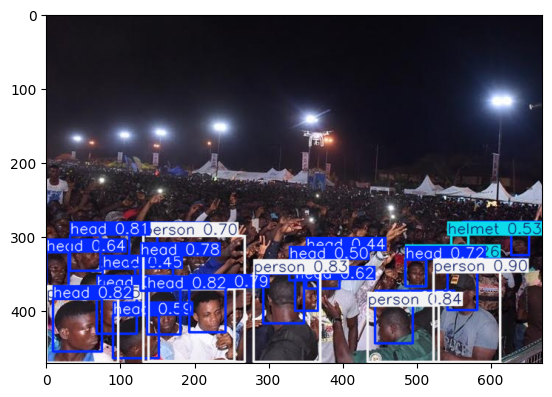

In [7]:
predict_and_save(
    source_file="https://hei.org.ng/wp-content/uploads/2019/12/crowd-shows.jpg",
    dest_file="runs/detect/predict/crowd-shows.png"
)


image 1/1 /home/victorvu-tran-01/Documents/code/i-soft/icam-factory/Cover-16.webp: 448x640 7 helmets, 7 persons, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


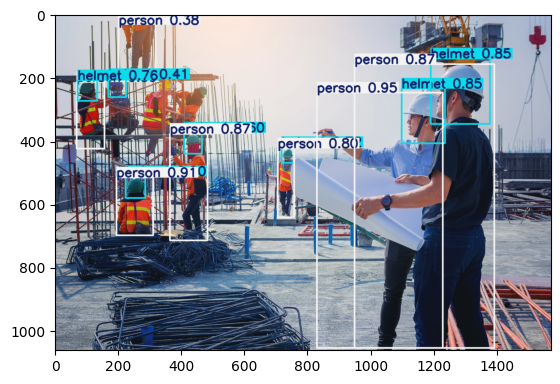

In [8]:
predict_and_save(
    source_file="https://detecttechnologies.com/wp-content/uploads/2025/06/Cover-16.webp"
)


image 1/1 /home/victorvu-tran-01/Documents/code/i-soft/icam-factory/types-of-construction-workers​-975x548.webp: 384x640 7 helmets, 8 persons, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


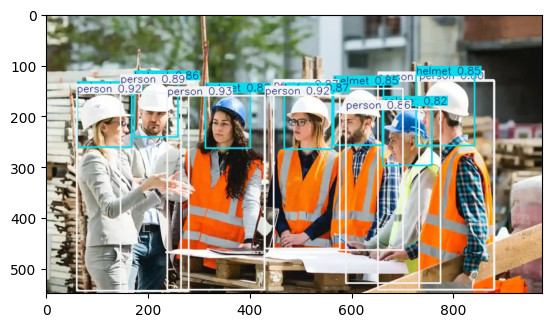

In [9]:
predict_and_save(
    source_file="https://www.infra.ratepersqft.com/wp-content/uploads/2025/01/types-of-construction-workers%E2%80%8B-975x548.webp",
)